I have used the following methods.

* I have implemented DeepLabv3+ stemmed from this Keras example[1,2],
* I converted the original masks to <b><span style="color:#e74c3c;"> binary masks and applied dilated operation </span></b> in the image preprocessing stage,
* I used <b><span style="color:#e74c3c;"> histogram equalization and smoothing</span></b> for original images in the image preprocessing stage,
* <b>Dice coefficient</b> and <b>Jaccard index</b> implementation[3],
* I used <b> <b><span style="color:#e74c3c;"> DeepLabv3+ implementation</span></b> with ResNet50 backbone,
* Used tf.data for input pipeline,
* <b>A Custom layer</b> for convolution operation,
* <b>A Custom layer</b> for Dilated Spatial Pyramid Pooling operation,
* <b>Custom callback</b> for predicting one sample from test dataset during training each epochs[4]

## Evaluation Results

| for 15 epochs    | Train (900 imgs) | Valid (135 imgs) | Test (100 imgs) |
|------------------|------------------|------------------|-----------------|
| Loss             | 0.0357           | 0.0399           | 0.2296          |
| Dice Loss        | 0.0657           | 0.0693           | 0.2111          |
| Dice Coefficient | 0.9343           | 0.9307           | 0.7889          |
| Jaccard Index    | 0.8770           | 0.8709           | 0.6601          |

    
## Model Improvement During Training
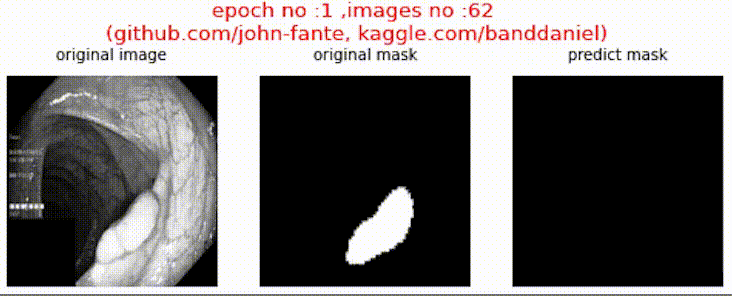
    
## Predictions
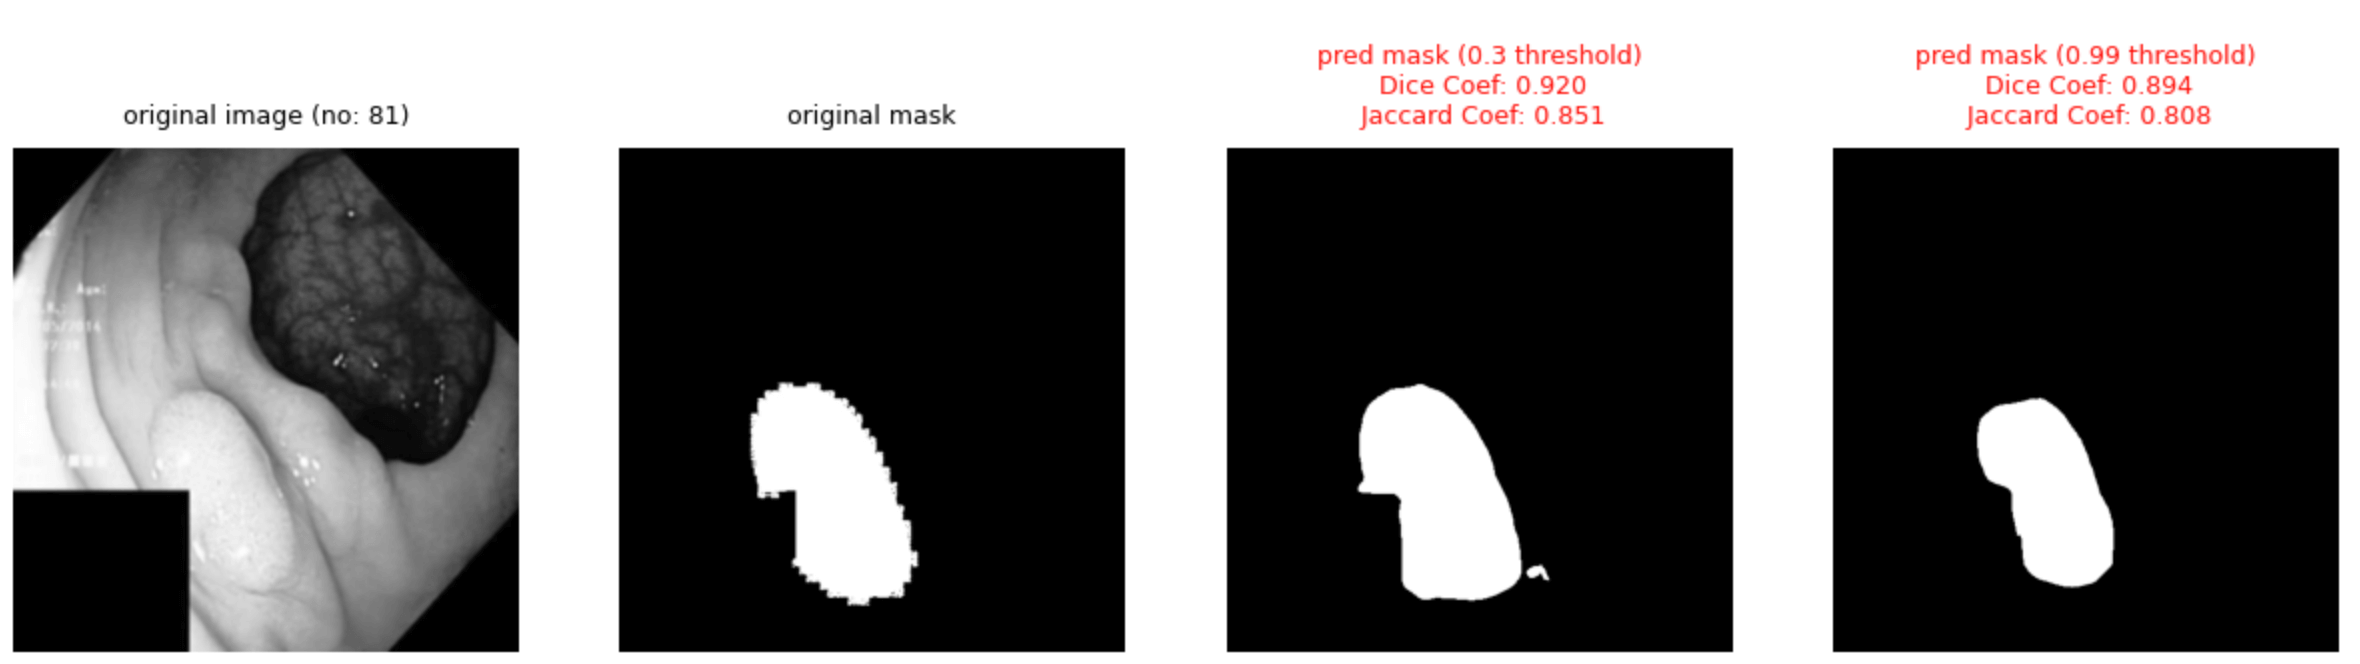
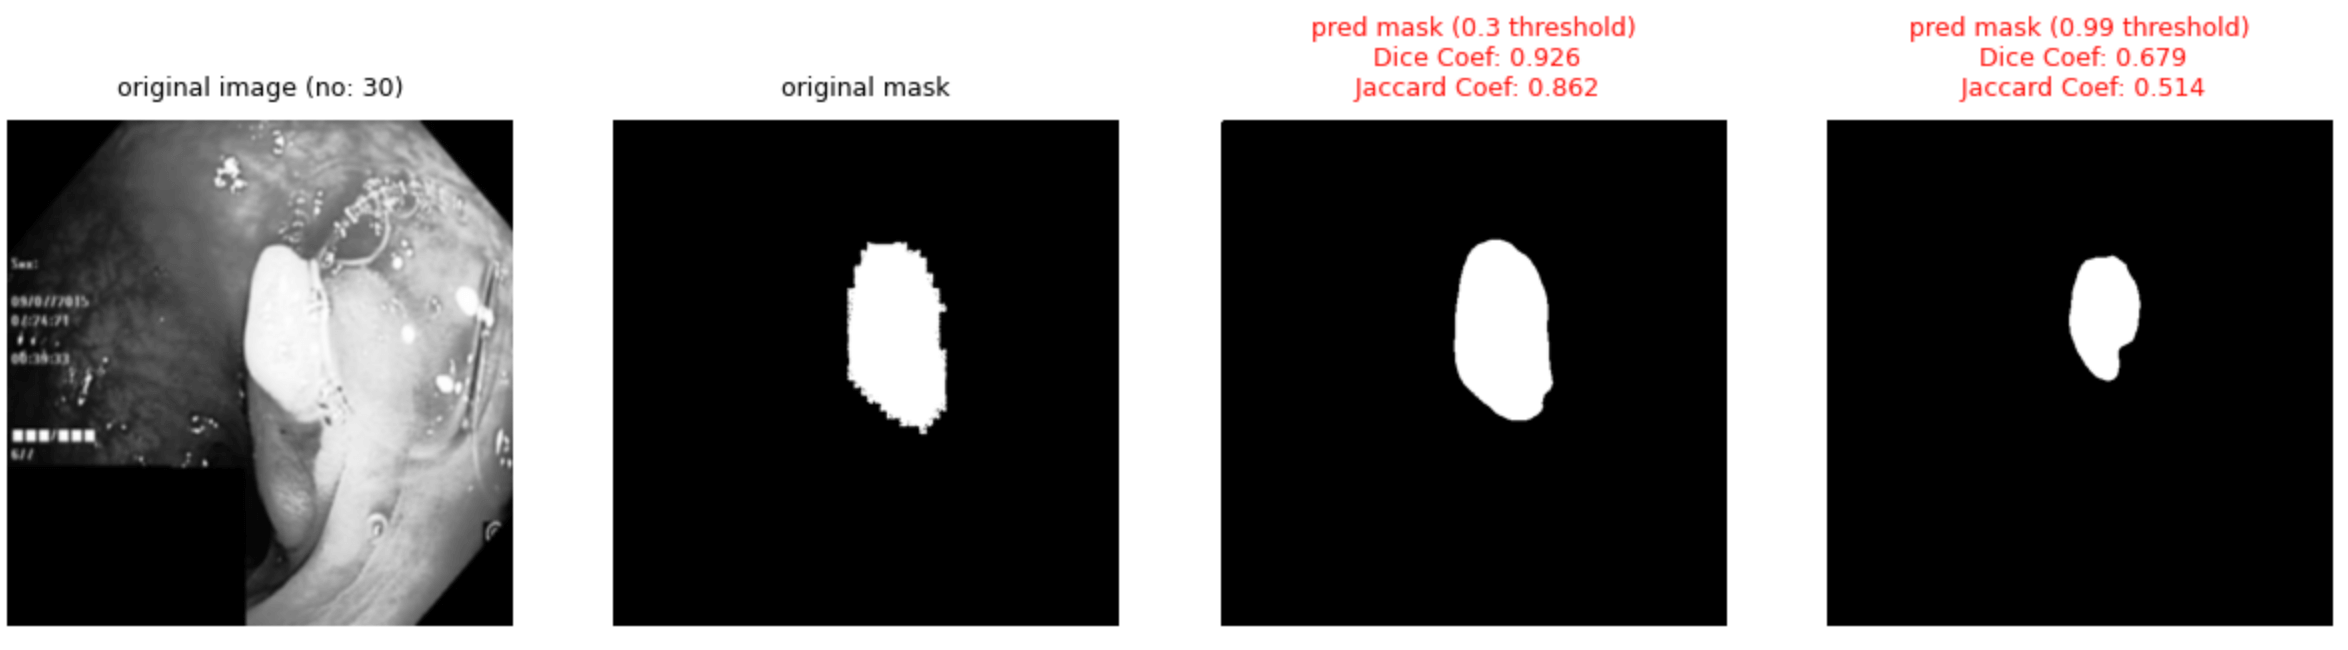


## My Another Segmentation Projects

* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain tumor/anomaly segmentation with Unet using TPU](https://github.com/john-fante/brain-tumor-segmentation-tpu)
* [Iris Segmentation U-net w/TPU (Dice Coef: 0.94)](https://www.kaggle.com/code/banddaniel/iris-segmentation-u-net-w-tpu-dice-coef-0-94)
* [Eye Conjunctiva Segmentation with U-Net using TPU (Dice: 0.91, Jaccard: 0.82)](https://github.com/john-fante/eye-conjunctiva-segmentation)
* [Brain tissue segmentation with Unet using TPU (Dice: 0.88)](https://github.com/john-fante/brain-tissue-segmentation-tpu)


## References
1. https://keras.io/examples/vision/deeplabv3_plus/#building-the-deeplabv3-model
2. Chen, L.-C., Zhu, Y., Papandreou, G., Schroff, F., & Adam, H. (2018). Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1802.02611
3. https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient
4. My another custom callbacks for Tensorflow (https://github.com/john-fante/my-tensorflow-custom-callbacks)

In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout,Concatenate, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, MaxPooling2D, AveragePooling2D, Dense, concatenate, GlobalAveragePooling2D


SEED = 65
IMG_SIZE = 512,512
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Image </span> Preprocessing


In [2]:
os.mkdir(os.path.join('/kaggle/working/', 'converted_masks'))
os.mkdir(os.path.join('/kaggle/working/', 'converted_images'))

In [3]:
# A function that is used for converting binary masks and dilated masks 

def convert_binary_masks(main_path, target_path):
    for i in sorted(os.listdir(main_path)):
        img = cv2.imread(os.path.join(main_path, i ))
        f, bw_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)
        kernel = np.ones((2,2))
        dilated_mask = cv2.dilate(bw_img, kernel, iterations = 1)
        cv2.imwrite(os.path.join(target_path,i), dilated_mask[:,::,0])

In [4]:
# A function that is used for applying histogram equalization and smoothing with gaussian blur

def image_cvt_histeq_smooth(main_path, target_path):
    main_imgs = sorted(os.listdir(main_path))
    for i in main_imgs :

        img = cv2.imread(os.path.join(main_path, i))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.blur(img,(4,4))

        cv2.imwrite(os.path.join(target_path, i), img)

In [5]:
# Applying preprocessing functions to images and masks

convert_binary_masks('/kaggle/input/kvasirseg/Kvasir-SEG/masks', '/kaggle/working/converted_masks')
image_cvt_histeq_smooth('/kaggle/input/kvasirseg/Kvasir-SEG/images', '/kaggle/working/converted_images')

(-0.5, 618.5, 530.5, -0.5)

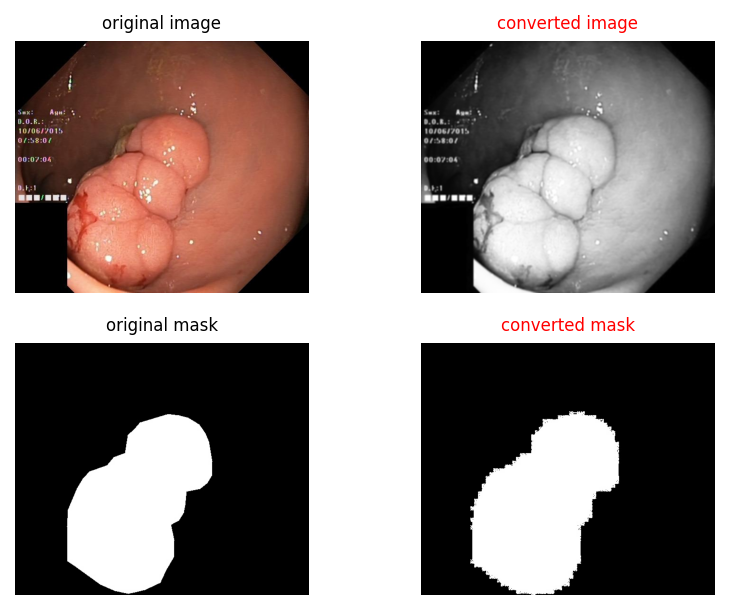

In [6]:
img_original = cv2.imread("/kaggle/input/kvasirseg/Kvasir-SEG/images/cju8bbznkrf5g0871jncffynk.jpg")
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

mask_original = cv2.imread("/kaggle/input/kvasirseg/Kvasir-SEG/masks/cju8bbznkrf5g0871jncffynk.jpg")


img_converted =cv2.imread('/kaggle/working/converted_images/cju8bbznkrf5g0871jncffynk.jpg') 
mask_converted =cv2.imread('/kaggle/working/converted_masks/cju8bbznkrf5g0871jncffynk.jpg') 


fig, ax = plt.subplots(2,2, dpi = 150)
ax[0][0].imshow(img_original)
ax[0][0].set_title('original image', fontsize = 8)
ax[0][0].axis('off')

ax[0][1].imshow(img_converted)
ax[0][1].set_title('converted image', fontsize = 8, color = 'red')
ax[0][1].axis('off')

ax[1][0].imshow(mask_original)
ax[1][0].set_title('original mask', fontsize = 8)
ax[1][0].axis('off')

ax[1][1].imshow(mask_converted)
ax[1][1].set_title('converted mask', fontsize = 8, color = 'red')
ax[1][1].axis('off')

# <span style="color:#e74c3c;"> Creating </span> Datasets


In [7]:
# Creating main dataframe contains image paths and their mask paths.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


images = create_images_list('/kaggle/working/converted_images')
masks = create_images_list('/kaggle/working/converted_masks')

full_data = pd.DataFrame({'image': images, 'mask': masks})

full_data = shuffle(full_data).reset_index().drop(columns=['index'])

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets


In [8]:
X_data, X_test, y_data, y_test = train_test_split(full_data['image'], full_data['mask'], test_size = 0.1, random_state = SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_data, y_data, test_size = 0.15, random_state = SEED + 1)

print("X_train shape -> ", X_data.shape)
print("X_val shape -> ", X_validation.shape)
print("X_test shape -> ", X_test.shape)

X_train shape ->  (900,)
X_val shape ->  (135,)
X_test shape ->  (100,)


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [9]:
# Reading and resizing images and masks

def img_preprocessing(image, mask):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_jpeg(mask, channels = 1)
    mask = tf.image.resize(mask, size = (IMG_SIZE))
    mask = tf.cast(mask, tf.float32) / 255.0
    
    return img, mask


In [10]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((X_data, y_data))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .shuffle(X_data.shape[0])
                 .prefetch(AUTO))


validation_loader = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
validation_dataset = (validation_loader
                      .map(img_preprocessing, num_parallel_calls = AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> Creating </span> Custom Layers

In [11]:
# Convolutional block class

class ConvBlock(Layer):
    def __init__(self, filters, kernel_size, dilation_rate, batch = False, padding = 'same', activation = 'relu', use_bias = False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.batch = batch
        self.padding = padding
        self.activation = activation
        self.use_bias = use_bias
        
        self.conv = Conv2D(filters, kernel_size = kernel_size, dilation_rate = dilation_rate, padding = padding, use_bias = use_bias, kernel_initializer = 'he_normal')
        self.norm = BatchNormalization()
        self.act = Activation(activation)
    
    def call(self, inputs):
        X = self.conv(inputs)
        if self.batch:
            X = self.norm(X)
            X = self.act(X)
            return X
        else:
            X = self.act(X)
            return X
            

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size" : self.kernel_size,
            "dilation_rate" : self.dilation_rate,
            "activation" : self.act,
            "batch" : self.batch }


In [12]:
# DilatedSpatialPyramidPooling class for DeepLabv3+ model

class DilatedSpatialPyramidPooling(Layer):
    def __init__(self, input_layer, kernel_1, kernel_2, kernel_3, kernel_4, dil1, dil2, dil3, dil4, **kwargs):
        super(DilatedSpatialPyramidPooling, self).__init__(**kwargs)
        self.input_layer = input_layer
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.kernel_3 = kernel_3
        self.kernel_4 = kernel_4
        self.dil1 = dil1
        self.dil2 = dil2
        self.dil3 = dil3
        self.dil4 = dil4
 
        self.pool = AveragePooling2D(pool_size = (input_layer.shape[-3], input_layer.shape[-2]))
        self.convblock = ConvBlock(filters = 256, kernel_size=1, dilation_rate=1, batch = True, use_bias=True)
        self.outpool = UpSampling2D(size=(32,32), interpolation="bilinear")
        self.convout1 = ConvBlock(filters = 256, kernel_size = kernel_1, dilation_rate = dil1, batch = True)
        self.convout2 = ConvBlock(filters = 256, kernel_size = kernel_2, dilation_rate = dil2, batch = True)
        self.convout3 = ConvBlock(filters = 256, kernel_size = kernel_3, dilation_rate = dil3, batch = True)
        self.convout4 = ConvBlock(filters = 256, kernel_size = kernel_4, dilation_rate = dil4, batch = True)
        self.outconv = ConvBlock(filters = 256, kernel_size = 1, dilation_rate=1, batch = True)

    
    def call(self, inputs):
        X = self.pool(inputs)
        X = self.convblock(X)
        X_p = self.outpool(X)
        X_1 = self.convout1(inputs)
        X_2 = self.convout2(inputs)
        X_3 = self.convout3(inputs)
        X_4 = self.convout4(inputs)
        
        C = concatenate([X_p, X_1, X_2, X_3, X_4], axis = -1)
        X = self.outconv(C)
        return X

    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "input_layer": self.input_layer,
            "kernel_1" : self.kernel_1,
            "kernel_2" : self.kernel_2,
            "kernel_3" : self.kernel_3,
            "kernel_4" : self.kernel_4,
            "dil1" : self.dil1,
            "dil2" : self.dil2,
            "dil3" : self.dil3,
            "dil4" : self.dil4}

In [13]:
# Creating Dice and Jaccard metrics

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1e-6 )
    return jaccard

In [14]:
# Custom callback for predicting one sample from test dataset during training each epochs

class PredictDuringTraining(Callback):
    def on_epoch_end(self, epochs, logs = None ):
        
        if (epochs + 1) % 1 == 0:
            samples = list(test_dataset.take(-1))
        
            idxs = np.random.permutation(X_test.shape[0])[0]
            batch_idx = idxs // BATCH_SIZE
            image_idx = idxs-batch_idx * BATCH_SIZE
            idx = idxs
        
            image = samples[batch_idx][0][image_idx] 
            mask = samples[batch_idx][1][image_idx]
        
            pred_mask = self.model.predict(image[np.newaxis,...], verbose = 0)
            pred_ = np.squeeze(pred_mask)
            threshold  = 0.3
            bitmap_pred = (pred_ > threshold).astype(np.uint8)
        
            fig, axs = plt.subplots(1,3, figsize = (5,2) ,dpi = 120)
            fig.suptitle( 'epoch no :' + str(epochs + 1)  + ' ,images no :' + str(idx) + '\n (github.com/john-fante, kaggle.com/banddaniel)', color='red', fontsize = 8 )

            axs[0].imshow(image , cmap = 'gray')
            axs[0].axis('off')
            axs[0].set_title('original image', fontsize = 6)

            axs[1].imshow(mask, cmap = 'gray')
            axs[1].axis('off')
            axs[1].set_title('original mask', fontsize = 6)

            axs[2].imshow( bitmap_pred, cmap = 'gray')
            axs[2].axis('off')
            axs[2].set_title('predict mask', fontsize = 6)
                            
            plt.tight_layout()
            plt.show()
        else:
            pass

# <span style="color:#e74c3c;"> DeepLabv3+</span> Model


In [15]:
inp = Input(shape = (*IMG_SIZE ,3))
pretrained = ResNet50(weights="imagenet", include_top=False, input_tensor=inp)
X = pretrained.get_layer("conv4_block6_2_relu").output
X = DilatedSpatialPyramidPooling(X, kernel_1 = 1, kernel_2 = 3, kernel_3 = 3, kernel_4 = 3,
                                 dil1 = 1, dil2 = 6, dil3 = 12, dil4 = 18)(X)

X_1 = UpSampling2D(size = (IMG_SIZE[0] // 4 // X.shape[1], IMG_SIZE[0] // 4 // X.shape[2]), interpolation="bilinear")(X)

X_2 = pretrained.get_layer("conv2_block3_2_relu").output
X_2 = ConvBlock(filters=48, kernel_size=1, dilation_rate =1)(X_2)

X = Concatenate(axis=-1)([X_1, X_2])
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = ConvBlock(filters = 256, kernel_size = 3, dilation_rate = 1)(X)
X = UpSampling2D(size = (IMG_SIZE[0] // X.shape[1], IMG_SIZE[0] // X.shape[2]), interpolation="bilinear")(X)

out = Conv2D(1, 1 ,activation ='sigmoid', padding = 'same')(X)

model = Model(inputs = inp, outputs = out)
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy' , metrics = [dice_coef_loss, dice_coef, jaccard]) 
my_callbacks = [PredictDuringTraining()]

94765736/94765736 [==============================] - 1s 0us/step


# <span style="color:#e74c3c;"> Training </span> 


Epoch 1/15
113/113 [==============================] - ETA: 0s - loss: 0.3998 - dice_coef_loss: 0.6756 - dice_coef: 0.3244 - jaccard: 0.1958

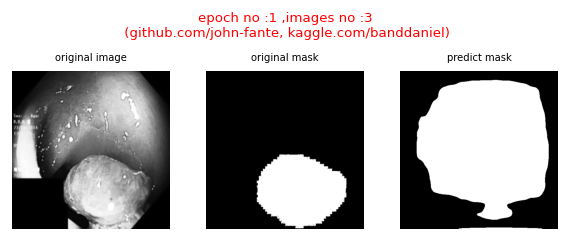

113/113 [==============================] - 112s 478ms/step - loss: 0.3998 - dice_coef_loss: 0.6756 - dice_coef: 0.3244 - jaccard: 0.1958 - val_loss: 0.5294 - val_dice_coef_loss: 0.6590 - val_dice_coef: 0.3410 - val_jaccard: 0.2067
Epoch 2/15
113/113 [==============================] - ETA: 0s - loss: 0.2913 - dice_coef_loss: 0.5416 - dice_coef: 0.4584 - jaccard: 0.2996

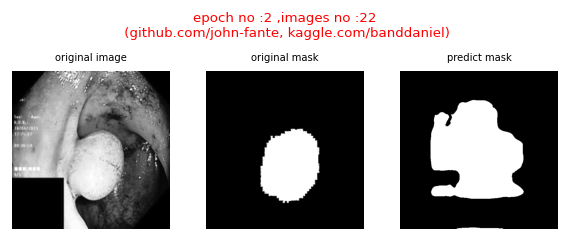

113/113 [==============================] - 51s 407ms/step - loss: 0.2913 - dice_coef_loss: 0.5416 - dice_coef: 0.4584 - jaccard: 0.2996 - val_loss: 0.4194 - val_dice_coef_loss: 0.7298 - val_dice_coef: 0.2702 - val_jaccard: 0.1566
Epoch 3/15
113/113 [==============================] - ETA: 0s - loss: 0.2453 - dice_coef_loss: 0.4485 - dice_coef: 0.5515 - jaccard: 0.3836

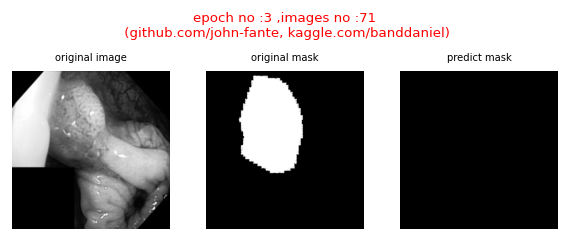

113/113 [==============================] - 51s 407ms/step - loss: 0.2453 - dice_coef_loss: 0.4485 - dice_coef: 0.5515 - jaccard: 0.3836 - val_loss: 0.7251 - val_dice_coef_loss: 0.9638 - val_dice_coef: 0.0362 - val_jaccard: 0.0184
Epoch 4/15
113/113 [==============================] - ETA: 0s - loss: 0.2137 - dice_coef_loss: 0.3881 - dice_coef: 0.6119 - jaccard: 0.4445

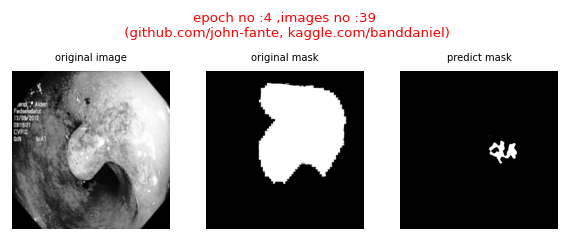

113/113 [==============================] - 50s 401ms/step - loss: 0.2137 - dice_coef_loss: 0.3881 - dice_coef: 0.6119 - jaccard: 0.4445 - val_loss: 0.4256 - val_dice_coef_loss: 0.7875 - val_dice_coef: 0.2125 - val_jaccard: 0.1191
Epoch 5/15
113/113 [==============================] - ETA: 0s - loss: 0.1813 - dice_coef_loss: 0.3261 - dice_coef: 0.6739 - jaccard: 0.5114

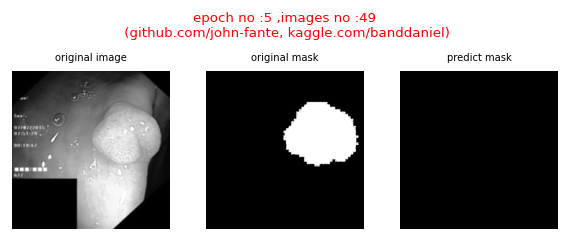

113/113 [==============================] - 51s 407ms/step - loss: 0.1813 - dice_coef_loss: 0.3261 - dice_coef: 0.6739 - jaccard: 0.5114 - val_loss: 0.5947 - val_dice_coef_loss: 0.9119 - val_dice_coef: 0.0881 - val_jaccard: 0.0461
Epoch 6/15
113/113 [==============================] - ETA: 0s - loss: 0.1507 - dice_coef_loss: 0.2717 - dice_coef: 0.7283 - jaccard: 0.5760

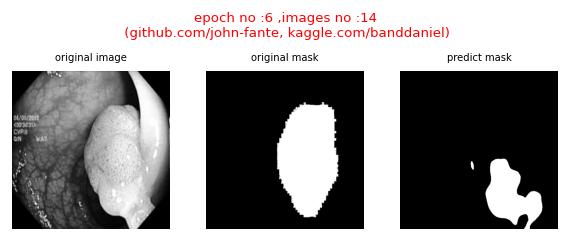

113/113 [==============================] - 52s 407ms/step - loss: 0.1507 - dice_coef_loss: 0.2717 - dice_coef: 0.7283 - jaccard: 0.5760 - val_loss: 0.4241 - val_dice_coef_loss: 0.6963 - val_dice_coef: 0.3037 - val_jaccard: 0.1808
Epoch 7/15
113/113 [==============================] - ETA: 0s - loss: 0.1365 - dice_coef_loss: 0.2438 - dice_coef: 0.7562 - jaccard: 0.6122

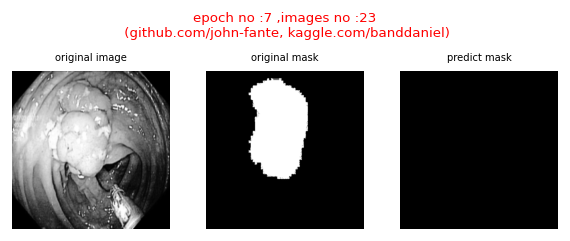

113/113 [==============================] - 51s 404ms/step - loss: 0.1365 - dice_coef_loss: 0.2438 - dice_coef: 0.7562 - jaccard: 0.6122 - val_loss: 0.3996 - val_dice_coef_loss: 0.6276 - val_dice_coef: 0.3724 - val_jaccard: 0.2319
Epoch 8/15
113/113 [==============================] - ETA: 0s - loss: 0.1149 - dice_coef_loss: 0.2082 - dice_coef: 0.7918 - jaccard: 0.6581

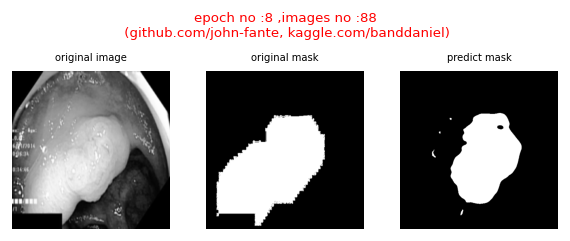

113/113 [==============================] - 50s 401ms/step - loss: 0.1149 - dice_coef_loss: 0.2082 - dice_coef: 0.7918 - jaccard: 0.6581 - val_loss: 0.2051 - val_dice_coef_loss: 0.3599 - val_dice_coef: 0.6401 - val_jaccard: 0.4729
Epoch 9/15
113/113 [==============================] - ETA: 0s - loss: 0.0933 - dice_coef_loss: 0.1678 - dice_coef: 0.8322 - jaccard: 0.7152

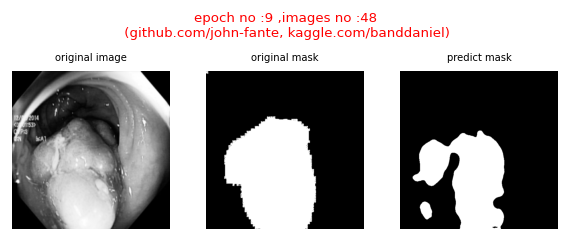

113/113 [==============================] - 51s 407ms/step - loss: 0.0933 - dice_coef_loss: 0.1678 - dice_coef: 0.8322 - jaccard: 0.7152 - val_loss: 0.2347 - val_dice_coef_loss: 0.2913 - val_dice_coef: 0.7087 - val_jaccard: 0.5531
Epoch 10/15
113/113 [==============================] - ETA: 0s - loss: 0.0778 - dice_coef_loss: 0.1407 - dice_coef: 0.8593 - jaccard: 0.7560

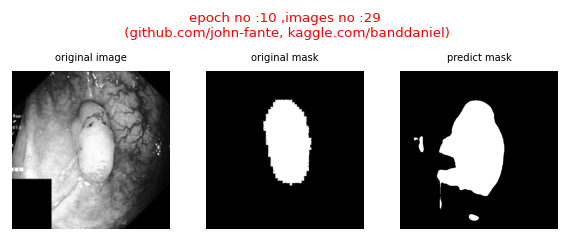

113/113 [==============================] - 50s 401ms/step - loss: 0.0778 - dice_coef_loss: 0.1407 - dice_coef: 0.8593 - jaccard: 0.7560 - val_loss: 0.2098 - val_dice_coef_loss: 0.2834 - val_dice_coef: 0.7166 - val_jaccard: 0.5618
Epoch 11/15
113/113 [==============================] - ETA: 0s - loss: 0.0674 - dice_coef_loss: 0.1234 - dice_coef: 0.8766 - jaccard: 0.7816

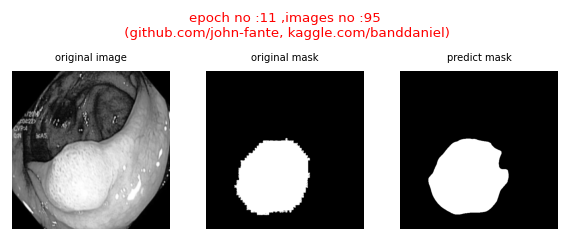

113/113 [==============================] - 52s 407ms/step - loss: 0.0674 - dice_coef_loss: 0.1234 - dice_coef: 0.8766 - jaccard: 0.7816 - val_loss: 0.1222 - val_dice_coef_loss: 0.2033 - val_dice_coef: 0.7967 - val_jaccard: 0.6641
Epoch 12/15
113/113 [==============================] - ETA: 0s - loss: 0.0686 - dice_coef_loss: 0.1264 - dice_coef: 0.8736 - jaccard: 0.7776

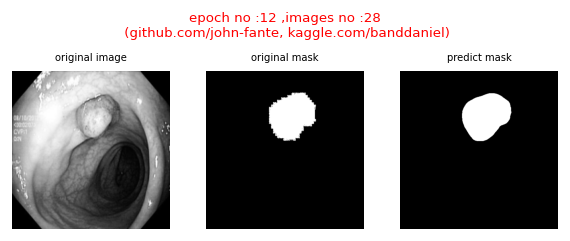

113/113 [==============================] - 52s 413ms/step - loss: 0.0686 - dice_coef_loss: 0.1264 - dice_coef: 0.8736 - jaccard: 0.7776 - val_loss: 0.0881 - val_dice_coef_loss: 0.1326 - val_dice_coef: 0.8674 - val_jaccard: 0.7678
Epoch 13/15
113/113 [==============================] - ETA: 0s - loss: 0.0495 - dice_coef_loss: 0.0910 - dice_coef: 0.9090 - jaccard: 0.8338

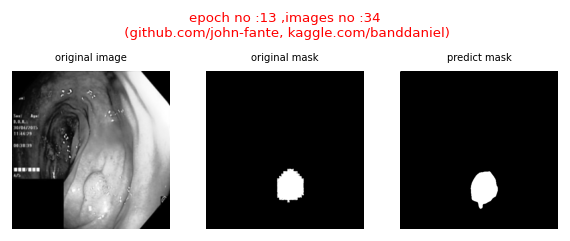

113/113 [==============================] - 52s 407ms/step - loss: 0.0495 - dice_coef_loss: 0.0910 - dice_coef: 0.9090 - jaccard: 0.8338 - val_loss: 0.0854 - val_dice_coef_loss: 0.1240 - val_dice_coef: 0.8760 - val_jaccard: 0.7809
Epoch 14/15
113/113 [==============================] - ETA: 0s - loss: 0.0443 - dice_coef_loss: 0.0806 - dice_coef: 0.9194 - jaccard: 0.8514

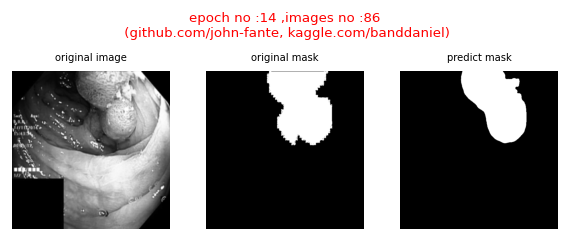

113/113 [==============================] - 51s 407ms/step - loss: 0.0443 - dice_coef_loss: 0.0806 - dice_coef: 0.9194 - jaccard: 0.8514 - val_loss: 0.0793 - val_dice_coef_loss: 0.1093 - val_dice_coef: 0.8907 - val_jaccard: 0.8038
Epoch 15/15
113/113 [==============================] - ETA: 0s - loss: 0.0371 - dice_coef_loss: 0.0691 - dice_coef: 0.9309 - jaccard: 0.8712

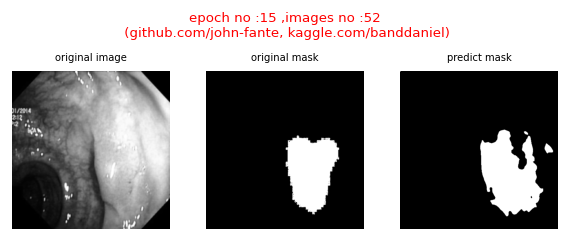

113/113 [==============================] - 50s 401ms/step - loss: 0.0371 - dice_coef_loss: 0.0691 - dice_coef: 0.9309 - jaccard: 0.8712 - val_loss: 0.0539 - val_dice_coef_loss: 0.0873 - val_dice_coef: 0.9127 - val_jaccard: 0.8400


In [16]:
hist = model.fit(train_dataset, batch_size = BATCH_SIZE, epochs = 15, validation_data = validation_dataset, callbacks = my_callbacks)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

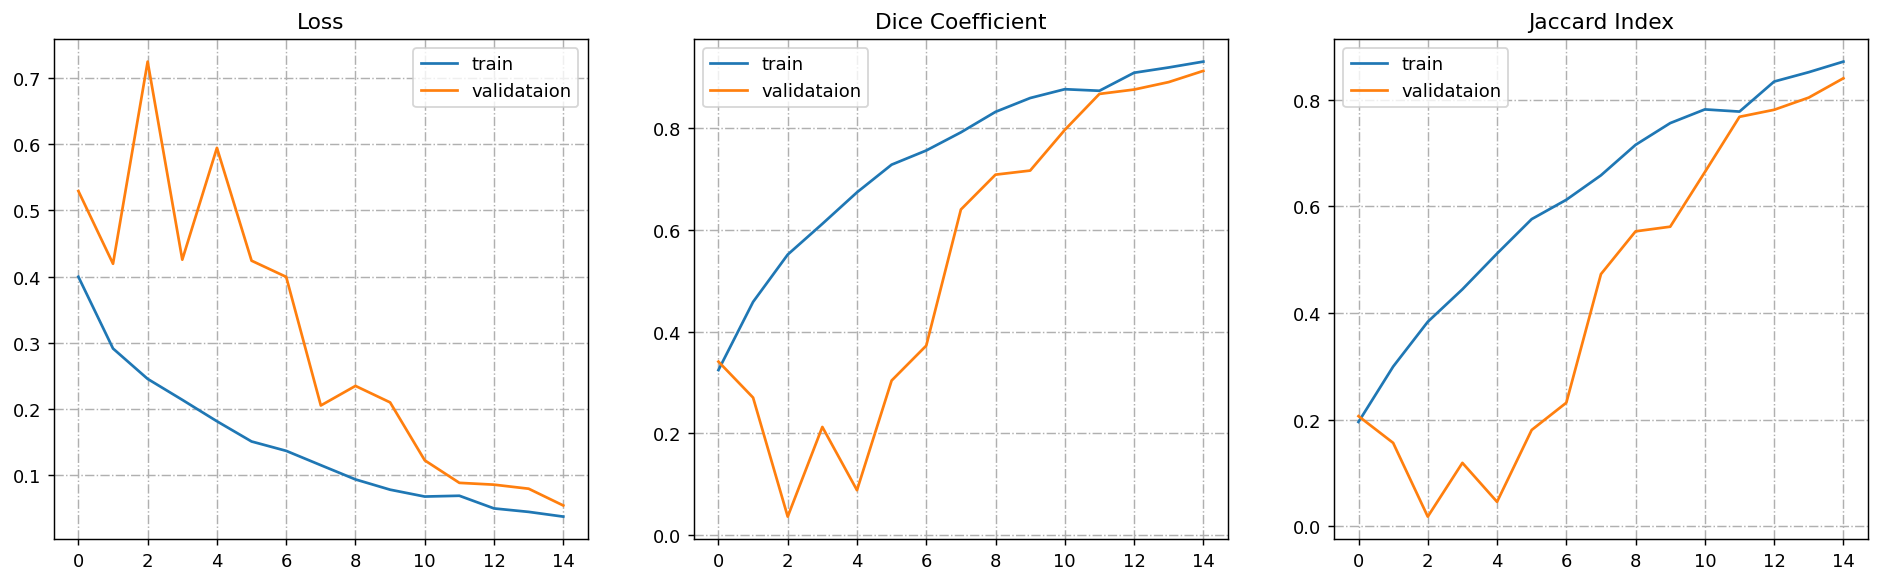

In [17]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Dice Coefficient")
axs[1].plot(hist.history['dice_coef'])
axs[1].plot(hist.history['val_dice_coef'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Jaccard Index")
axs[2].plot(hist.history['jaccard'])
axs[2].plot(hist.history['val_jaccard'])
axs[2].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test and Validation </span> Evaluation

In [18]:
val_eval = model.evaluate(validation_dataset)
test_eval = model.evaluate(test_dataset)

13/13 [==============================] - 2s 110ms/step - loss: 0.1707 - dice_coef_loss: 0.2233 - dice_coef: 0.7767 - jaccard: 0.6414


# <span style="color:#e74c3c;"> Test </span> Predictions

In [19]:
test_take1 =  validation_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())
    
pred_ = np.squeeze(pred)

threshold_1  = 0.3 #threshold for prediction
bitmap_pred_1 = (pred_ > threshold_1).astype(np.uint8)

threshold_2  = 0.99 #threshold for prediction
bitmap_pred_2 = (pred_ > threshold_2).astype(np.uint8)

17/17 [==============================] - 3s 108ms/step


In [20]:
# A function that calculating dice and jaccard metrics for prediction
def calc_dice_jaccard_for_prediction(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = tf.cast(y_true_f, tf.uint16)
    y_pred_f = tf.cast(y_pred_f, tf.uint16)

    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2 * intersection+1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)
    jaccard = intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection)
    
    return dice.numpy(),jaccard.numpy()


# A function that creating 3 random images in the test set and prediction it
def random_test_sample_with_prediction():
    idxs = np.random.permutation(len(y_test_take))[:3]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

   
    fig, axs = plt.subplots(3,4, figsize = (10, 10 ) ,dpi = 150)
    
    for i in range(3):
        image = test_take1_[batch_idx[i]][0][image_idx[i]]
        mask = test_take1_[batch_idx[i]][1][image_idx[i]]
        pred_mask_1 = bitmap_pred_1[idx[i]]
        pred_mask_2 = bitmap_pred_2[idx[i]]
        
        dice1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[0]
        jac1 = calc_dice_jaccard_for_prediction(mask, pred_mask_1)[1]
        
        dice2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[0]
        jac2= calc_dice_jaccard_for_prediction(mask, pred_mask_2)[1]
        

        axs[i][0].imshow(image , cmap = 'gray')
        axs[i][0].axis('off')
        axs[i][0].set_title('original image (no: ' + str(idxs[i]) + ")", fontsize = 6)

        axs[i][1].imshow(mask, cmap = 'gray')
        axs[i][1].axis('off')
        axs[i][1].set_title('original mask', fontsize = 6)

        axs[i][2].imshow(pred_mask_1 , cmap = 'gray')
        axs[i][2].axis('off')
        axs[i][2].set_title('pred mask (0.3 threshold)'
                            + '\n Dice Coef: {0:0.3f}'.format(dice1) 
                            + '\n Jaccard Coef: {0:0.3f}'.format(jac1), color = 'red', fontsize = 6)
    
        axs[i][3].imshow(pred_mask_2 , cmap = 'gray')
        axs[i][3].axis('off')
        axs[i][3].set_title('pred mask (0.99 threshold)' + '\n Dice Coef: {0:0.3f}'.format(dice2) + '\n Jaccard Coef: {0:0.3f}'.format(jac2), color = 'red', fontsize = 6)

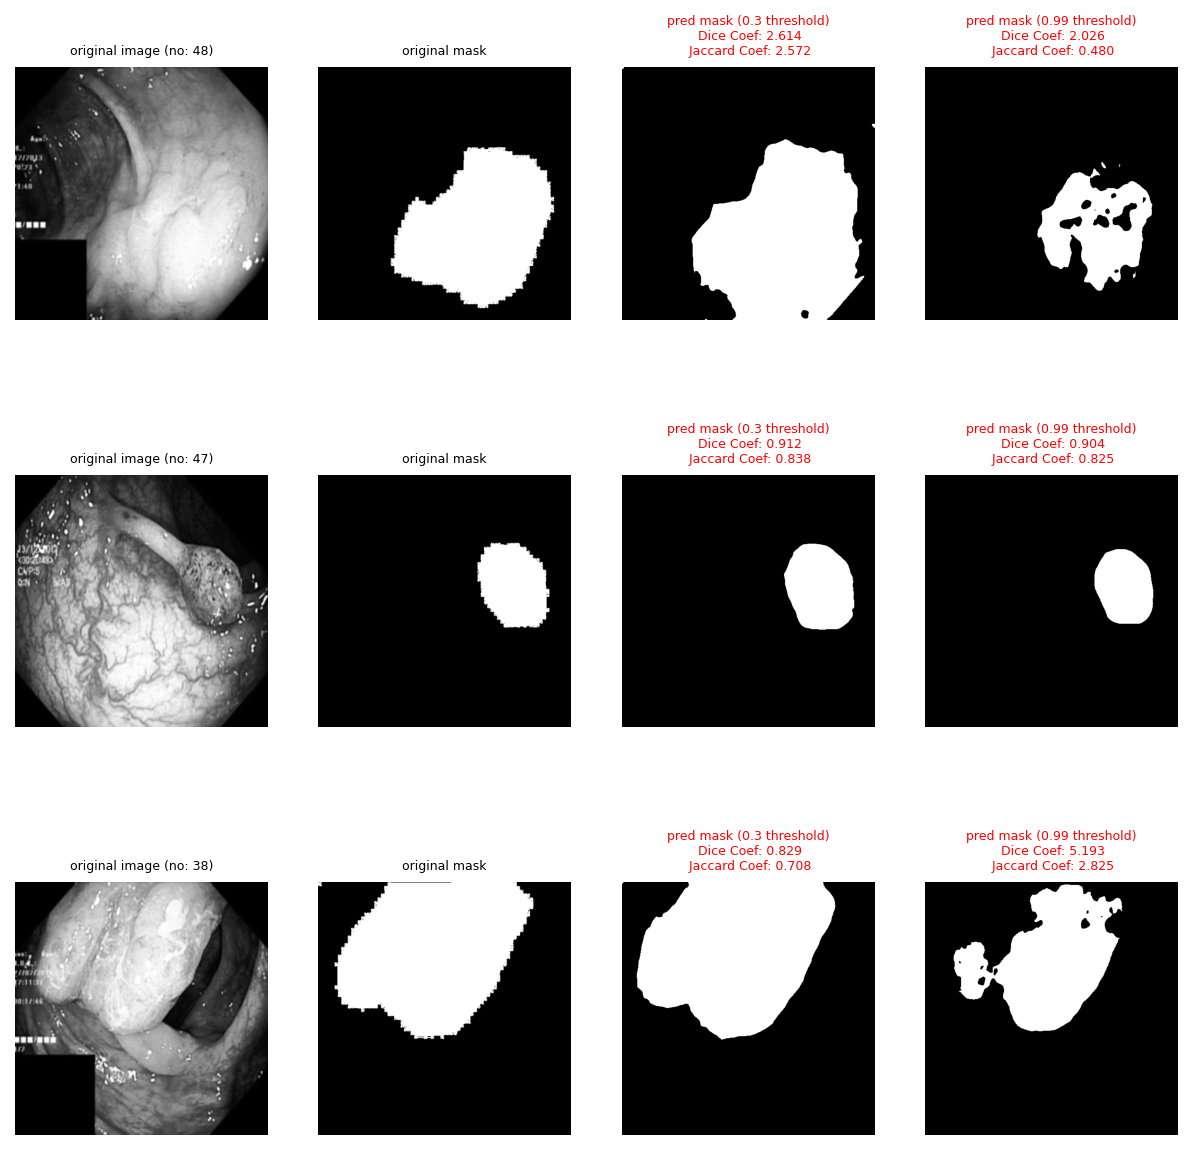

In [21]:
random_test_sample_with_prediction()